# Proyek Klasifikasi Gambar: [Fruits Classification]
- **Nama:** [Bismi Padia]
- **Email:** [bismiipadiaa@gmail.com]
- **ID Dicoding:** [B25B8M111]

## Import Semua Packages/Library yang Digunakan

In [3]:
import os
import shutil
import zipfile
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical

import cv2
from PIL import Image
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


## Data Preparation

In [4]:
!pip freeze > requirements.txt

In [5]:
!cat requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.10.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.15
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.16.5
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.10.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.3.0
arviz==0.22.0
astropy==7.1.0
astropy-iers-data==0.2025.9.15.0.37.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
Authlib==1.6.4
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.21.0
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.21.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.8.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.8.3
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.3
chex==0.1.90
clara

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
print(tf.__version__)

2.19.0


In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bismipadiafpmipa","key":"408c518793121aaf6b16561059ea7c58"}'}

In [12]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d utkarshsaxenadn/fruits-classification
!unzip fruits-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fruits Classification/train/Grape/Grape (1950).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1952).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1953).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1955).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1956).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1957).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1958).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1959).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (196).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1960).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1961).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1962).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1963).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1964).jpeg  
  inflating:

In [13]:
!ls

'Fruits Classification'   fruits-classification.zip


In [14]:
import os
import shutil

#### Split Dataset

In [15]:
train_dir = "Fruits Classification/train"
test_dir = "Fruits Classification/test"
valid_dir = "Fruits Classification/valid"

combined_dir = "Fruits Classification/dataset"

In [16]:
os.makedirs(combined_dir, exist_ok=True)

In [17]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(valid_dir):
    category_dir = os.path.join(valid_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

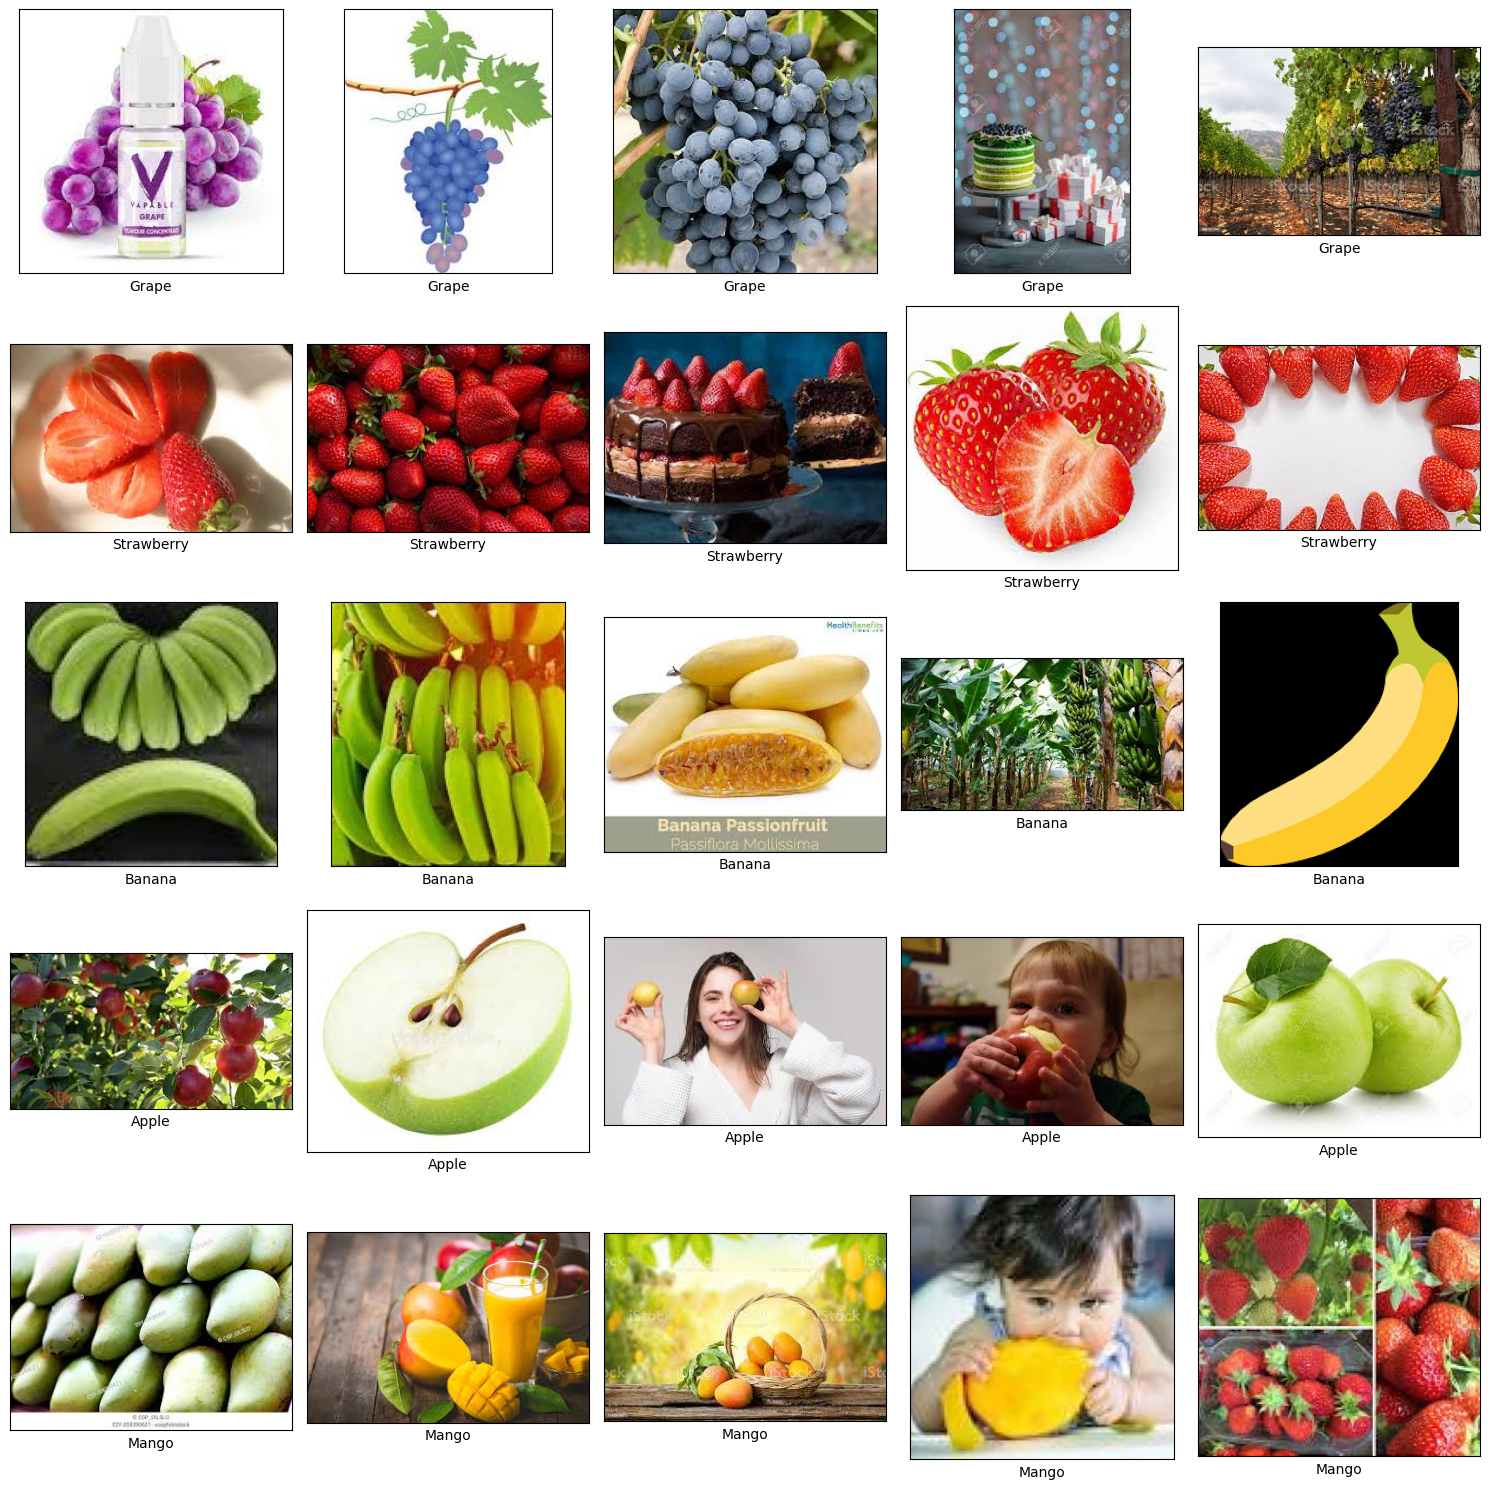

In [18]:
fruit_image = {}

path = "Fruits Classification/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    fruit_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "Fruits Classification/dataset/"

fig, axs = plt.subplots(len(fruit_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(fruit_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

In [19]:
!pip install seaborn
import seaborn as sns

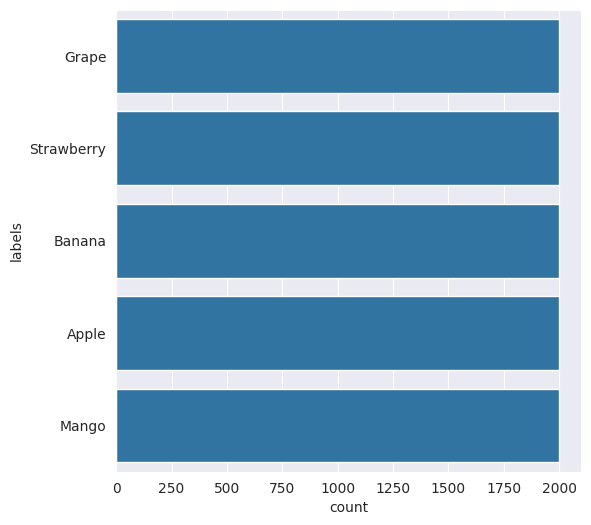

In [20]:
fruit_image = "Fruits Classification/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(fruit_image):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [21]:
fruit= 'Fruits Classification/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(fruit):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

labels
Apple         2000
Banana        2000
Grape         2000
Mango         2000
Strawberry    2000
dtype: int64

In [22]:
X = df['path']
y = df['labels']

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=300, stratify=y_trainval
)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Train: 6400, Validation: 1600, Test: 2000


In [23]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_va = pd.DataFrame({'path':X_val,'labels':y_val,'set':'validation'})

In [24]:
df_all = pd.concat([df_tr, df_te, df_va], ignore_index=True)

print(df_all.groupby(['set', 'labels']).size(), '\n')
print(df_all.sample(5))

datasource_path = "fruit/dataset/"
dataset_path = "Dataset-Final/"

set         labels    
test        Apple          400
            Banana         400
            Grape          400
            Mango          400
            Strawberry     400
train       Apple         1280
            Banana        1280
            Grape         1280
            Mango         1280
            Strawberry    1280
validation  Apple          320
            Banana         320
            Grape          320
            Mango          320
            Strawberry     320
dtype: int64 

                                                   path  labels    set
4098  Fruits Classification/dataset/Mango/Mango (76)...   Mango  train
6127  Fruits Classification/dataset/Grape/Grape (172...   Grape  train
4423  Fruits Classification/dataset/Banana/Banana (2...  Banana  train
1990  Fruits Classification/dataset/Grape/Grape (112...   Grape  train
6957  Fruits Classification/dataset/Grape/Grape (100...   Grape   test


In [25]:
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [26]:
TRAIN_DIR = "Dataset-Final/train/"
VAL_DIR   = "Dataset-Final/validation/"
TEST_DIR  = "Dataset-Final/test/"

classes = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']

for subset_name, subset_dir in zip(['Train', 'Validation', 'Test'], [TRAIN_DIR, VAL_DIR, TEST_DIR]):
    print(f"\n- {subset_name} set -")
    for fruit in classes:
        class_dir = os.path.join(subset_dir, fruit)
        if os.path.isdir(class_dir):
            print(f"{fruit}: {len(os.listdir(class_dir))} images")



- Train set -
Apple: 1280 images
Banana: 1280 images
Grape: 1280 images
Mango: 1280 images
Strawberry: 1280 images

- Validation set -
Apple: 320 images
Banana: 320 images
Grape: 320 images
Mango: 320 images
Strawberry: 320 images

- Test set -
Apple: 400 images
Banana: 400 images
Grape: 400 images
Mango: 400 images
Strawberry: 400 images


## Modelling

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150,150),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(150,150),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150,150),
    color_mode="rgb",
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 6400 images belonging to 5 classes.
Found 1600 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [28]:
model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))

model_1.add(Dense(train_generator.num_classes, activation='softmax'))

model_1.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model_1.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,717 (5.35 MB)

 Trainable params: 1,403,525 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [29]:
from google.colab import output
output.eval_js('''
  function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
  }
  setInterval(ConnectButton, 60000);
''')

1

In [32]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = sorted(os.listdir("Dataset-Final/train"))
num_classes = len(classes)

class_indices = {cls_name: i for i, cls_name in enumerate(classes)}

labels = []
for cls_name, idx in class_indices.items():
    cls_path = os.path.join("Dataset-Final/train", cls_name)
    n_files = len(os.listdir(cls_path))
    labels.extend([idx]*n_files)
labels = np.array(labels)

class_weights_values = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=labels
)

class_weights_dict = {i: w for i, w in enumerate(class_weights_values)}

In [33]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

history_finetune = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

/tmp/ipython-input-212547076.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.2025 - loss: 1.9448 - val_accuracy: 0.3294 - val_loss: 1.4781 - learning_rate: 1.0000e-05
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.3195 - loss: 1.5817 - val_accuracy: 0.5619 - val_loss: 1.1675 - learning_rate: 1.0000e-05
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.4277 - loss: 1.3857 - val_accuracy: 0.6587 - val_loss: 0.9597 - learning_rate: 1.0000e-05
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.5118 - loss: 1.2230 - val_accuracy: 0.7131 - val_loss: 0.8068 - learning_rate: 1.0000e-05
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.5886 - loss: 1.0538 - val_accuracy: 0.7538 - val_loss: 0.7029 - learning_rate: 1.0000e-05
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.6200 - loss: 0.9833 - val_accuracy: 0.7800 - val_loss: 0.6380 - learning_rate: 1.0000e-05
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - acc

## Evaluasi dan Visualisasi

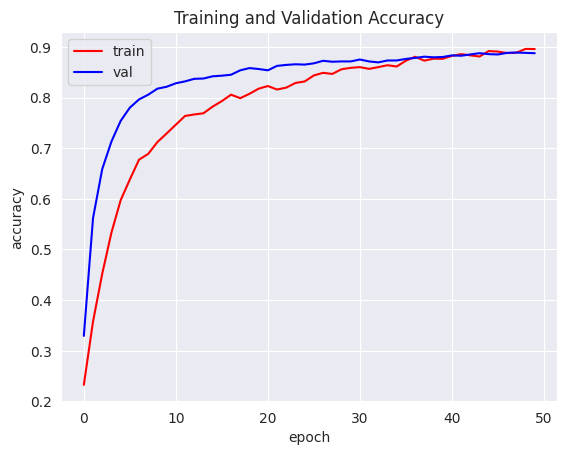

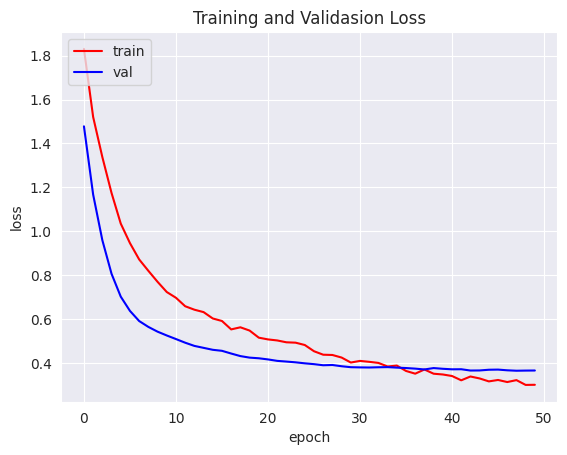

In [34]:
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validasion Loss')
plt.show()

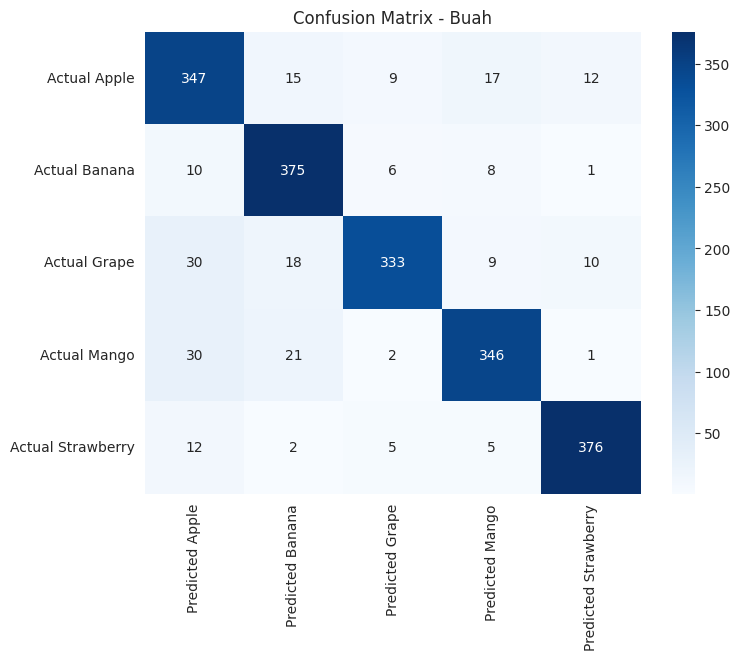


Classification Report:

              precision    recall  f1-score   support

       Apple     0.8089    0.8675    0.8372       400
      Banana     0.8701    0.9375    0.9025       400
       Grape     0.9380    0.8325    0.8821       400
       Mango     0.8987    0.8650    0.8815       400
  Strawberry     0.9400    0.9400    0.9400       400

    accuracy                         0.8885      2000
   macro avg     0.8911    0.8885    0.8887      2000
weighted avg     0.8911    0.8885    0.8887      2000



In [35]:
test_generator.reset()

preds = model.predict(test_generator, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred, labels=range(len(class_labels))),
    index=[f"Actual {cls}" for cls in class_labels],
    columns=[f"Predicted {cls}" for cls in class_labels]
)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Buah")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))


In [44]:
!ls

 Dataset-Final	'Fruits Classification'   fruits-classification.zip


## Konversi Model

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 223s 1us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 93s 63ms/step - accuracy: 0.3371 - loss: 1.8048 - val_accuracy: 0.5366 - val_loss: 1.3015
Epoch 2/2
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 122s 49ms/step - accuracy: 0.5461 - loss: 1.2786 - val_accuracy: 0.6254 - val_loss: 1.0653


Saved artifact at 'saved_model_demo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_607')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136568824335248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824336400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824336976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824335056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824337360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824337168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824337744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824337552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  adding: saved_model_demo/ (stored 0%)
  adding: saved_model_demo/variables/ (stored 0%)
  adding: saved_model_demo/variables/variables.data-00000-of-00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved artifact at '/tmp/tmpg8sok52b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_607')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136568824335248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824336400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824336976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824335056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824337360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824337168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824337744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136568824337552: TensorSpec(shape=(), dtype=tf.resource, name=None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

failed to lookup keras version from the file,
    this is likely a weight only file
  adding: tfjs_demo_model/ (stored 0%)
  adding: tfjs_demo_model/model.json (deflated 82%)
  adding: tfjs_demo_model/group1-shard1of1.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Prediksi H5 : 6, Label asli: 6


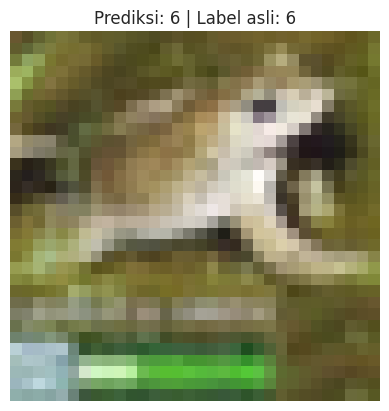

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflowjs as tfjs
from google.colab import files

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, validation_split=0.1)

model.save("demo_model.h5")
model.export("saved_model_demo")
!zip -r saved_model_demo.zip saved_model_demo
files.download("saved_model_demo.zip")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("demo_model.tflite", "wb") as f:
    f.write(tflite_model)
files.download("demo_model.tflite")

tfjs_target_dir = "tfjs_demo_model"
tfjs.converters.save_keras_model(model, tfjs_target_dir)
!zip -r tfjs_demo_model.zip tfjs_demo_model
files.download("tfjs_demo_model.zip")

idx = random.randint(0, len(x_test)-1)
img_array = x_test[idx:idx+1]
true_label = np.argmax(y_test[idx])

pred_h5 = model.predict(img_array)
class_h5 = np.argmax(pred_h5, axis=1)[0]

print(f"Prediksi H5 : {class_h5}, Label asli: {true_label}")

plt.imshow(x_test[idx])
plt.title(f"Prediksi: {class_h5} | Label asli: {true_label}")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


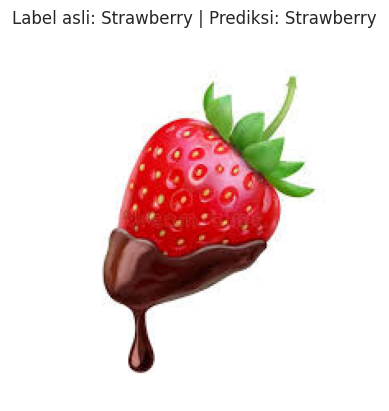

In [61]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow import keras

base_path = "Dataset-Final/train"
classes = sorted(os.listdir(base_path))
num_classes = len(classes)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

chosen_class = random.choice(classes)
class_path = os.path.join(base_path, chosen_class)
chosen_img = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, chosen_img)

img = image.load_img(img_path, target_size=(150,150))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

pred = model.predict(img_array)
pred_index = np.argmax(pred, axis=1)[0]
pred_class = classes[pred_index]

plt.imshow(image.load_img(img_path))
plt.title(f"Label asli: {chosen_class} | Prediksi: {pred_class}")
plt.axis("off")
plt.show()


In [64]:
!pip freeze > requirements.txt
from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

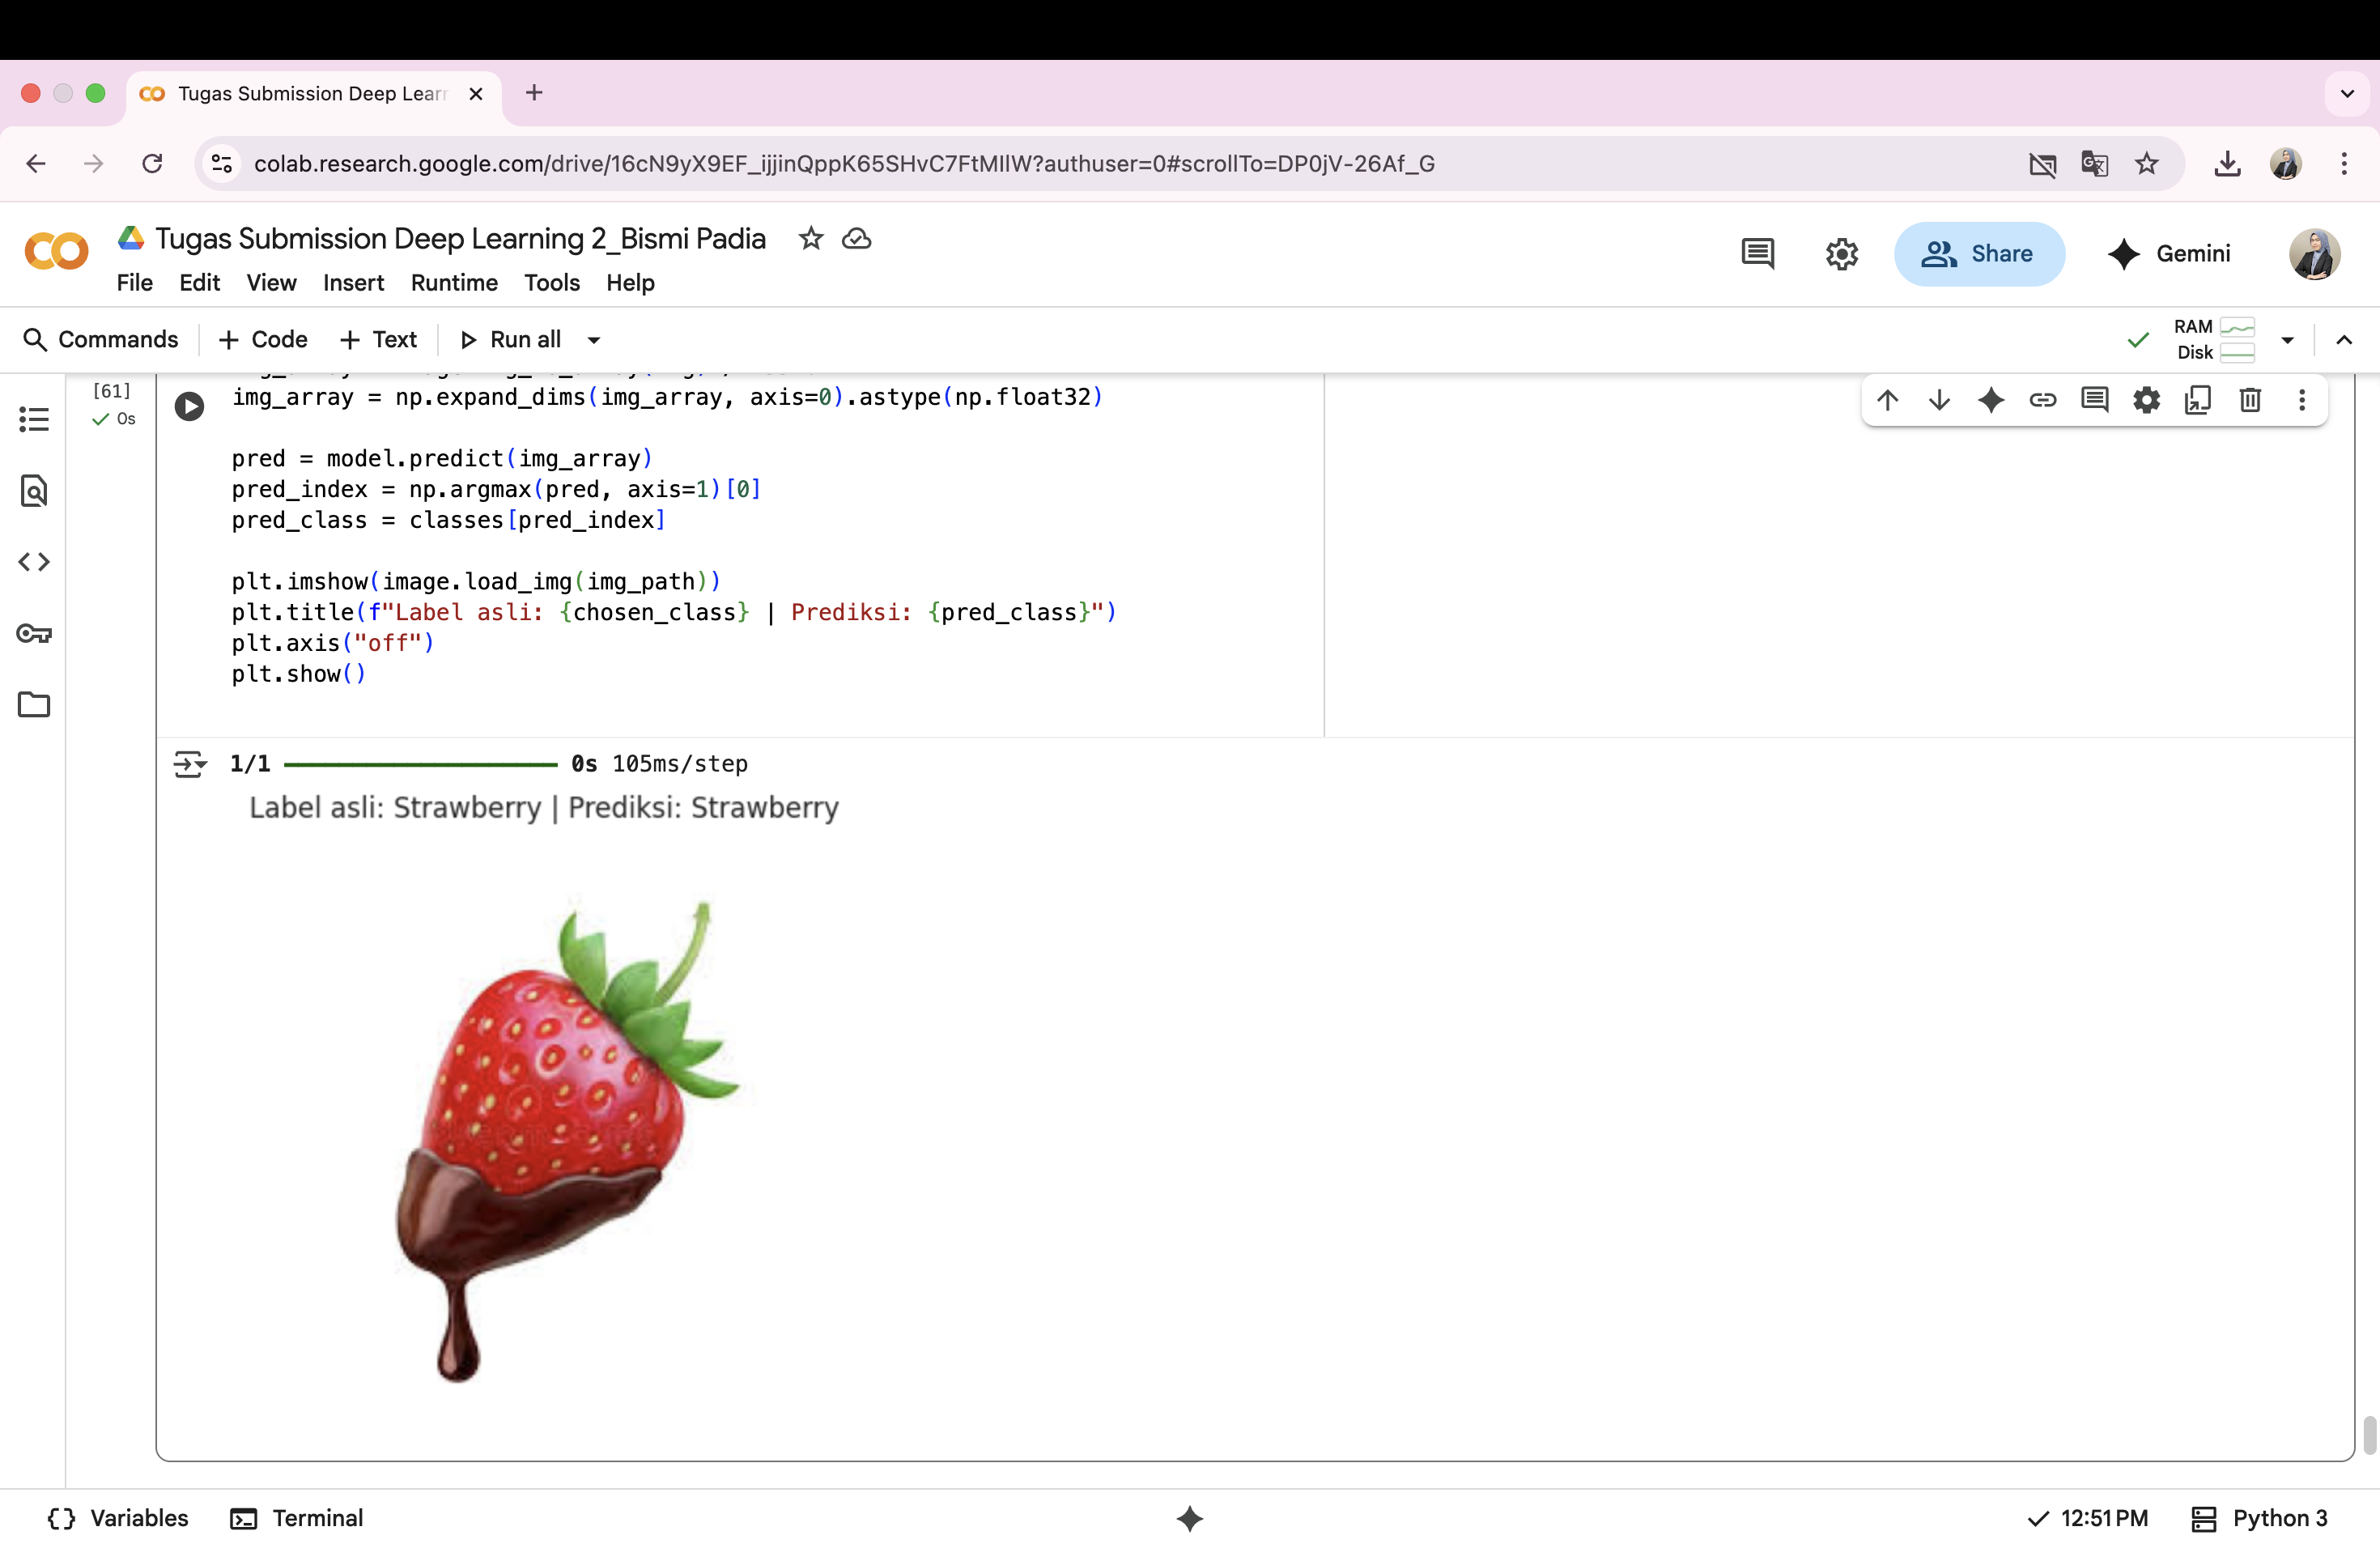